# P3 - SDCND Behavioral Cloning Project

The goal of this project is to drive a car around a virtual track autonomously using a deep neural network built using Keras. 

Due to time constraints, this version of the project is being optimized to run quickly on my local machine. Hopefully, in the future, I'll have time to go back and optimize for AWS.

## Import

In [88]:
import os, time, math, random, cv2, json, shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dropout, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display
from pathlib import Path
import json

%matplotlib inline

## Create functions to augment dataset

A few methods for augmenting images have been mentioned throughout the course so far. In addition, [this](http://benanne.github.io/2014/04/05/galaxy-zoo.html) blog post provides a little more insight and guidance into methods for augmenting images.

The following augmentations will be used on the provided (and later on the output from the simulator): 
1. Flip horizonatally
2. Randomly adjust brightness
3. Height shift
4. Width shift
5. Crop the unnecessary areas of the image

Another method to approaching these transformations would be to use ImageDataGenerator from keras.preprocessing.image. In this case, I wanted to write the functions as well as adjust the steering angle when necessary.

In [89]:
driving_data = pd.read_csv("driving_log.csv", index_col = False)
driving_data.columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']

center_image = process_new_image(driving_data['center'][0].strip())
rows, columns, channels = center_image.shape

In [81]:
# 1. Flip horizontally
def horizontal_flip(img, steering_angle):
    flipped = cv2.flip(img, 1) # positive (>0) flip code means flipping about y-axis
    steering_angle = steering_angle * -1 # change sign of steering angle to account for flip
    return flipped, steering_angle

# 2. Brighness shift
BRIGHT_VAL = 0.5
def brightness_shift(img):
    img_new = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # convert color spaces
    random_bright_val = BRIGHT_VAL + np.random.uniform() # random coefficient to shift brightness by
    img_new[:,:,2] = img_new[:,:,2] * random_bright_val    
    img_new = cv2.cvtColor(img_new, cv2.COLOR_HSV2RGB) # convert back to RGB
    return img_new

# 3./4. Height and width shift
WIDTH_SHIFT = 100
HEIGHT_SHIFT = 50
def height_width_shift(img, steer, translate_range):
    rows, columns, channels = img.shape
    
#     y
#     ^
#     |
#     |____> x

    translate_x = WIDTH_SHIFT * np.random.uniform() - WIDTH_SHIFT / 2
    translate_y = HEIGHT_SHIFT * np.random.uniform() - HEIGHT_SHIFT / 2
    transform = np.float32([[1, 0 , translate_x], [0, 1, translate_y]])
    steering_angle = steer + translate_x/translate_range * 2 * .2
    
    transformed_img = cv2.warpAffine(img, transform, (columns, rows)) # example warpAffine from http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
    return transformed_img, steering_angle, translate_x

threshold = 1
img_rows = 64
img_columns = 64
img_channels = 3

# Preprocess image files
def preprocessImage(img):
    shape = img.shape
    img = img[math.floor(shape[0]/4) : shape[0] - 25, 0:shape[1]]
    img = cv2.resize(img, (img_columns, img_rows), interpolation = cv2.INTER_AREA)
    return img

def process_new_image(name):
    #preprocess the image
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.-.5
    return img

# small angle shift to account for the three cameras
CAMERA_SHIFT = 0.25

def preprocess_image_train(csv_line):
    k = np.random.randint(3) # one each for center, left, right
    
    if (k == 0):
        file = csv_line["left"][0].strip()
        view_shift = CAMERA_SHIFT
    elif(k == 1):
        file = csv_line["center"][0].strip()
        view_shift = 0
    elif(k == 2):
        file = csv_line["right"][0].strip()
        view_shift = -CAMERA_SHIFT
    
    steering_angle = csv_line["steering_angle"][0] + view_shift
    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle, translate_x = height_width_shift(img, steering_angle, 100)
    img = brightness_shift(img)
    img = preprocessImage(img)
    img = np.array(img)

    # randomly flip the image
    if np.random.random() < 0.5:
        img, steering_angle = horizontal_flip(img, steering_angle)
    
    return img, steering_angle

def preprocess_image_predict(csv_line):
    file = csv_line['center'][0].strip()
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocessImage(img)
    img = np.array(img)
    return img

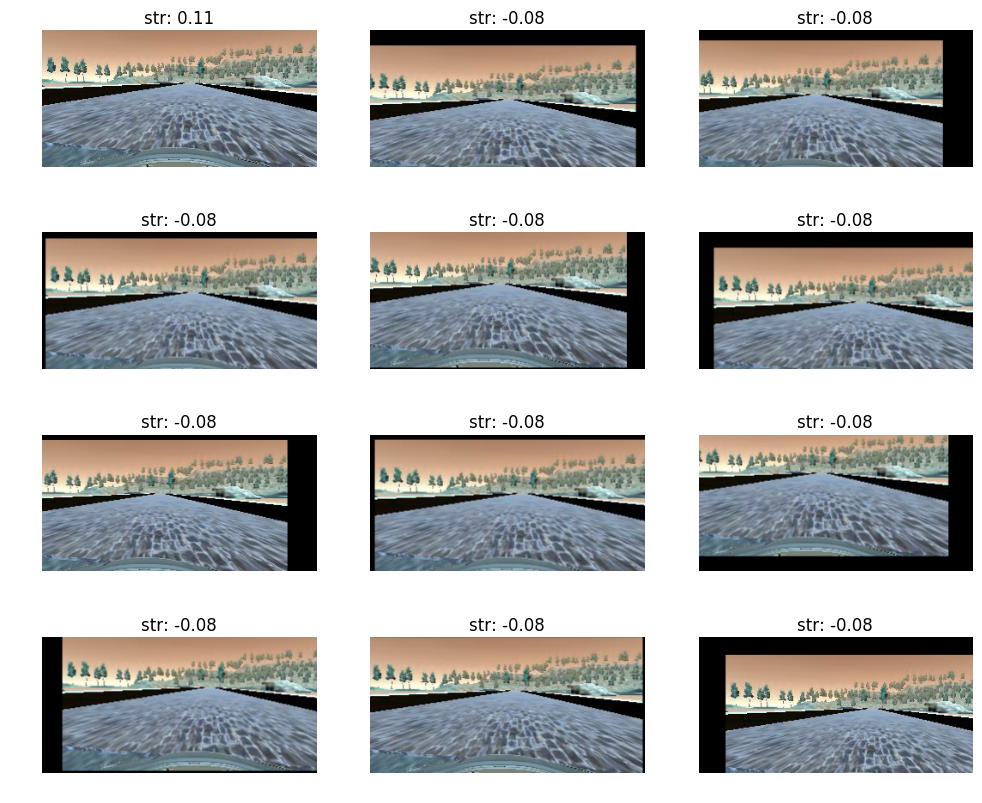

In [82]:
image = cv2.imread(driving_data['center'][85].strip())
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_angle,tr_x = height_width_shift(image,steer,100)
    plt.title('str: ' + str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');

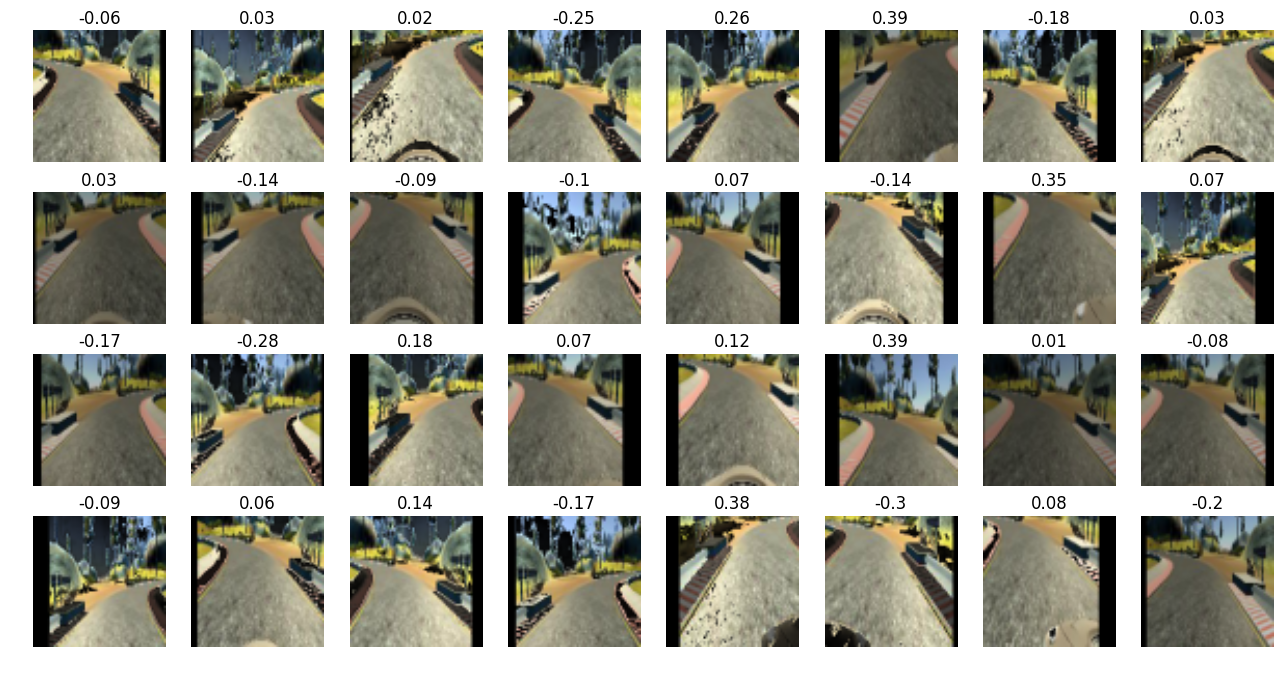

In [84]:
line_data = driving_data.iloc[[2]].reset_index()
plt.figure(figsize=(16,8))
for i in range(32):
    image,steer = preprocess_image_train(line_data)

    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))

## Generator

Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.

The keras generator for training with subsampling is created.

In [86]:
def generate_batch_train(data, batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_columns, img_channels))
    steering_batch = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            index = np.random.randint(len(data))
            line_data = data.iloc[[index]].reset_index()
            
            keep = 0
            while keep == 0:
                x, y = preprocess_image_train(line_data)
                
                if abs(y) < 0.15:
                    ind = np.random.uniform()
                    if ind > threshold:
                        keep = 1
                else:
                    keep = 1
            
            batch_images[batch_index] = x
            steering_batch[batch_index] = y
        yield batch_images, steering_batch

def generate_batch_valid(data):
    while 1:
        for line_index in range(len(data)):
            line_data = data.iloc[[line_index]].reset_index()
            x = preprocess_image_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steering_angle'][0]
            y = np.array([[y]])
            yield x, y
            
valid_gen = generate_batch_valid(driving_data)

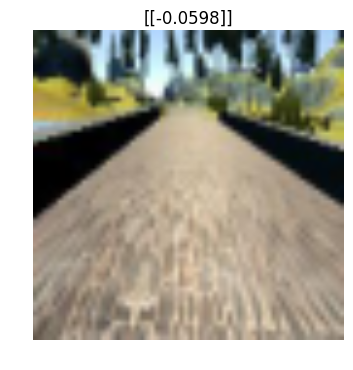

In [87]:
for i in range(100):
    next(valid_gen)
img, steer = next(valid_gen)
plt.imshow(img[0]);
plt.axis('off')
plt.title(str(np.round(steer,4)));

## Create Model

Based on comma.ai model for simplicity. The comma.ai model is relatively small in size and not too complicated. In addition, it's a proven model that's being used in production. The neural network is built using:

* A normalization layer to normalize all input images
* Convolutional layer, 16 8x8 feature maps, ELU activation function
* Convolutional layer, 32 8x8 feature maps, ELU activation function
* Convolutional layer, 64 8x8 feature maps, ELU activation function
* Flatten layer
* 20% Dropout
* ELU non-linearity layer
* Fully connected layer with 512 units, ELU activation function
* 50% Dropout
* ELU non-linearity layer
* Fully connected output layer

In [44]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(img_rows, img_columns, img_channels)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='Conv1'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv2'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv3'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512, activation='elu', name='FC1'))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1, name='output'))
    return model

## Load Data

In [34]:
driving_data = pd.read_csv("driving_log.csv", index_col = False)
driving_data.columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']

center_image = process_new_image(driving_data['center'][0].strip())
rows, columns, channels = center_image.shape

## Model

The model is created and the Adam optimization algorithm is used with a learning rate of 1e-4, beta_1 of 0.9, beta_2 of 0.999, epsilon of 1e-8, and no decay. 

In [35]:
model = get_model()
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse', metrics = [])

In [36]:
class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')

In [38]:
BATCH = 256
val = len(driving_data)

lifecycle_callback = LifecycleCallback()

validation_generator = generate_batch_valid(driving_data)

train_generator = generate_batch_train(driving_data, BATCH)
nb_vals = np.round(len(driving_data)/val) - 1
history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              samples_per_epoch = 20224, nb_epoch= 10,
                              nb_val_samples = val, verbose = 1,
                              callbacks = [lifecycle_callback])


BEGIN TRAINING
Epoch 1/10
20224/20224 [==============================] - 187s - loss: 0.0787 - val_loss: 0.0172
Epoch 2/10
20224/20224 [==============================] - 154s - loss: 0.0712 - val_loss: 0.0168
Epoch 3/10
20224/20224 [==============================] - 129s - loss: 0.0578 - val_loss: 0.0169
Epoch 4/10
20224/20224 [==============================] - 121s - loss: 0.0542 - val_loss: 0.0167
Epoch 5/10
20224/20224 [==============================] - 119s - loss: 0.0508 - val_loss: 0.0171
Epoch 6/10
20224/20224 [==============================] - 117s - loss: 0.0499 - val_loss: 0.0169
Epoch 7/10
20224/20224 [==============================] - 115s - loss: 0.0485 - val_loss: 0.0169
Epoch 8/10
20224/20224 [==============================] - 117s - loss: 0.0486 - val_loss: 0.0166
Epoch 9/10
20224/20224 [==============================] - 124s - loss: 0.0486 - val_loss: 0.0168
Epoch 10/10
20224/20224 [==============================] - 129s - loss: 0.0467 - val_loss: 0.0190
END TRAINING


## Save Model 

In [39]:
model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json.dump(model_json, json_file)
model.save_weights("./model.h5")
print("Saved!")

Saved!


## Plot Loss

dict_keys(['loss', 'val_loss'])


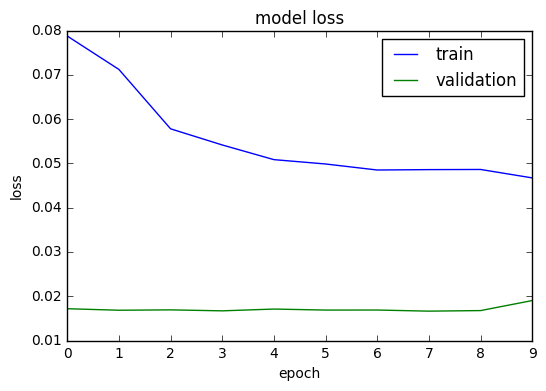

In [40]:
# list all data in history
print(history.history.keys())

# summarize history for epoch loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

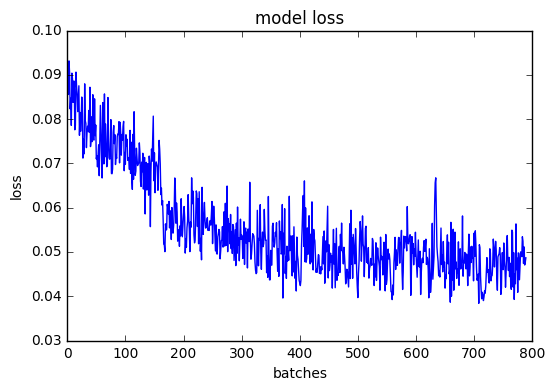

In [41]:
# summarize history for batch loss
batch_history = lifecycle_callback.losses
plt.plot(batch_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()